### Importing Necessary Libraries

In [12]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization, LSTM, Concatenate, Lambda
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [13]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [14]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [20]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [21]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [22]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [23]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

In [24]:
fine_tune_data = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 2048)

In [25]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [26]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2048)

In [27]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [28]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2048)

In [29]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

In [30]:
fine_tune_data_train_red = fine_tune_data_train

In [31]:
fine_tune_data_train_red.shape

(15200, 5, 2048)

In [32]:
fine_tune_data_test_red = fine_tune_data_test

In [33]:
fine_tune_data_test_red.shape

(800, 5, 2048)

## Fine-Tuning Models

The fine-tuning part of our model.

In [38]:
def ftmodel():
    inputs = Input(shape=(5, 2048))
    # x = Flatten()(inputs)
    x = BatchNormalization()(inputs)
    y = x[:,:4,:]
    z = x[:,-1,:]
    
    y = LSTM(1024, input_shape=(4, 2048))(y)
    
    x = Concatenate()([y, z]) 
    top_dropout_rate = 0.3
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    # x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='ResNet-FineTune')
    return model1

In [39]:
model1 = ftmodel()
model1.summary()

Model: "ResNet-FineTune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 2048)]    0           []                               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 5, 2048)     8192        ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 4, 2048)     0           ['batch_normalization_3[0][0]']  
 icingOpLambda)                                                                                   
                                                                                    

### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [40]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [41]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-4P-LSTM/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [42]:
history = model1.fit(fine_tune_data_train_red, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test_red, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-4P-LSTM/resnet-4p-model-weights")
model1.load_weights('./Models/ResNet-4P-LSTM/resnet-4p-model-weights')

Epoch 1/1000


2022-10-08 14:59:24.500348: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-08 14:59:25.273234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 14:59:26.404348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 14:59:29.005438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/19 [===========================>..] - ETA: 0s - loss: 1.9863 - accuracy: 0.4644

2022-10-08 14:59:31.104175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 14:59:31.180025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 7s 100ms/step - loss: 1.9580 - accuracy: 0.4726 - val_loss: 2.4245 - val_accuracy: 0.2700
Epoch 2/1000
19/19 [==============================] - 1s 78ms/step - loss: 1.1260 - accuracy: 0.6702 - val_loss: 2.2952 - val_accuracy: 0.3612
Epoch 3/1000
19/19 [==============================] - 1s 76ms/step - loss: 0.8295 - accuracy: 0.7489 - val_loss: 2.1877 - val_accuracy: 0.4262
Epoch 4/1000
19/19 [==============================] - 1s 75ms/step - loss: 0.6390 - accuracy: 0.8078 - val_loss: 2.0648 - val_accuracy: 0.5037
Epoch 5/1000
19/19 [==============================] - 1s 75ms/step - loss: 0.4981 - accuracy: 0.8545 - val_loss: 1.9530 - val_accuracy: 0.5437
Epoch 6/1000
19/19 [==============================] - 1s 74ms/step - loss: 0.3873 - accuracy: 0.8907 - val_loss: 1.8440 - val_accuracy: 0.5763
Epoch 7/1000
19/19 [==============================] - 1s 74ms/step - loss: 0.2938 - accuracy: 0.9224 - val_loss: 1.7226 - val_accuracy: 0.6025
Epoch 8/100

19/19 [==============================] - 1s 52ms/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 1.1357 - val_accuracy: 0.7587
Epoch 59/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 1.1444 - val_accuracy: 0.7612
Epoch 60/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 1.1515 - val_accuracy: 0.7587
Epoch 61/1000
19/19 [==============================] - 1s 54ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 1.1480 - val_accuracy: 0.7537
Epoch 62/1000
19/19 [==============================] - 1s 77ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 1.1548 - val_accuracy: 0.7525
Epoch 63/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 1.1668 - val_accuracy: 0.7512
Epoch 64/1000
19/19 [==============================] - 1s 54ms/step - loss: 0.0286 - accuracy: 0.9945 - val_loss: 1.7682 - val_accuracy: 0.6687
Epoch 

Epoch 115/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 1.1949 - val_accuracy: 0.7587
Epoch 116/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 1.1974 - val_accuracy: 0.7600
Epoch 117/1000
19/19 [==============================] - 1s 54ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 1.1892 - val_accuracy: 0.7600
Epoch 118/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 1.1970 - val_accuracy: 0.7625
Epoch 119/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 1.2006 - val_accuracy: 0.7612
Epoch 120/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 1.1928 - val_accuracy: 0.7637
Epoch 121/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 1.2078 - val_ac

19/19 [==============================] - 1s 51ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 1.2213 - val_accuracy: 0.7688
Epoch 172/1000
19/19 [==============================] - 1s 56ms/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 1.2122 - val_accuracy: 0.7738
Epoch 173/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 1.2313 - val_accuracy: 0.7713
Epoch 174/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 1.2183 - val_accuracy: 0.7675
Epoch 175/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 1.2414 - val_accuracy: 0.7688
Epoch 176/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 1.2229 - val_accuracy: 0.7688
Epoch 177/1000
19/19 [==============================] - 1s 54ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 1.2227 - val_accuracy: 0.7700


19/19 [==============================] - 1s 52ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.2331 - val_accuracy: 0.7662
Epoch 228/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.2626 - val_accuracy: 0.7562
Epoch 229/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 1.2395 - val_accuracy: 0.7612
Epoch 230/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.2401 - val_accuracy: 0.7688
Epoch 231/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.2388 - val_accuracy: 0.7738
Epoch 232/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 1.2767 - val_accuracy: 0.7487
Epoch 233/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 1.2392 - val_accuracy: 0.7575


19/19 [==============================] - 1s 51ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 1.2680 - val_accuracy: 0.7763
Epoch 284/1000
19/19 [==============================] - 1s 65ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 1.2740 - val_accuracy: 0.7788
Epoch 285/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 1.2735 - val_accuracy: 0.7775
Epoch 286/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.2687 - val_accuracy: 0.7763
Epoch 287/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.0021 - accuracy: 0.9999 - val_loss: 1.2697 - val_accuracy: 0.7788
Epoch 288/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 1.2705 - val_accuracy: 0.7800
Epoch 289/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.2716 - val_accuracy: 0.7800


19/19 [==============================] - 1s 55ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.2742 - val_accuracy: 0.7788
Epoch 340/1000
19/19 [==============================] - 1s 55ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 1.2826 - val_accuracy: 0.7812
Epoch 341/1000
19/19 [==============================] - 1s 57ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 1.2657 - val_accuracy: 0.7800
Epoch 342/1000
19/19 [==============================] - 1s 56ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 1.2663 - val_accuracy: 0.7788
Epoch 343/1000
19/19 [==============================] - 1s 58ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 1.2776 - val_accuracy: 0.7825
Epoch 344/1000
19/19 [==============================] - 1s 57ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 1.2726 - val_accuracy: 0.7837
Epoch 345/1000
19/19 [==============================] - 1s 58ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 1.2547 - val_accuracy: 0.7775


19/19 [==============================] - 1s 58ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 1.2950 - val_accuracy: 0.7688
Epoch 396/1000
19/19 [==============================] - 1s 57ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 1.2887 - val_accuracy: 0.7675
Epoch 397/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 1.2931 - val_accuracy: 0.7688
Epoch 398/1000
19/19 [==============================] - 1s 58ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.2980 - val_accuracy: 0.7675
Epoch 399/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 1.2994 - val_accuracy: 0.7713
Epoch 400/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.2963 - val_accuracy: 0.7662
Epoch 401/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 1.2957 - val_accuracy: 0.7688


19/19 [==============================] - 1s 54ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 1.2546 - val_accuracy: 0.7725
Epoch 452/1000
19/19 [==============================] - 1s 77ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.2427 - val_accuracy: 0.7738
Epoch 453/1000
19/19 [==============================] - 1s 74ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.2519 - val_accuracy: 0.7750
Epoch 454/1000
19/19 [==============================] - 1s 75ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 1.2500 - val_accuracy: 0.7763
Epoch 455/1000
19/19 [==============================] - 1s 51ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 1.2448 - val_accuracy: 0.7800
Epoch 456/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.2461 - val_accuracy: 0.7788
Epoch 457/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 1.2512 - val_accuracy: 0.7775


19/19 [==============================] - 1s 63ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.1856 - val_accuracy: 0.7763
Epoch 508/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.1593 - val_accuracy: 0.7700
Epoch 509/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 1.1950 - val_accuracy: 0.7763
Epoch 510/1000
19/19 [==============================] - 1s 65ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.1877 - val_accuracy: 0.7738
Epoch 511/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.1774 - val_accuracy: 0.7788
Epoch 512/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 1.1757 - val_accuracy: 0.7750
Epoch 513/1000
19/19 [==============================] - 1s 65ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.1789 - val_accuracy: 0.7750


19/19 [==============================] - 1s 66ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1568 - val_accuracy: 0.7738
Epoch 564/1000
19/19 [==============================] - 1s 67ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1365 - val_accuracy: 0.7788
Epoch 565/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.1510 - val_accuracy: 0.7738
Epoch 566/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1480 - val_accuracy: 0.7788
Epoch 567/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.1612 - val_accuracy: 0.7738
Epoch 568/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1355 - val_accuracy: 0.7750
Epoch 569/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.1406 - val_accuracy: 0.7763


19/19 [==============================] - 1s 68ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1225 - val_accuracy: 0.7763
Epoch 620/1000
19/19 [==============================] - 1s 66ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.1554 - val_accuracy: 0.7750
Epoch 621/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.1430 - val_accuracy: 0.7700
Epoch 622/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.1192 - val_accuracy: 0.7738
Epoch 623/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.1346 - val_accuracy: 0.7775
Epoch 624/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 1.1634 - val_accuracy: 0.7738
Epoch 625/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.1414 - val_accuracy: 0.7725


19/19 [==============================] - 1s 62ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 1.2293 - val_accuracy: 0.7612
Epoch 676/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 1.2540 - val_accuracy: 0.7600
Epoch 677/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 1.2627 - val_accuracy: 0.7500
Epoch 678/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.2653 - val_accuracy: 0.7562
Epoch 679/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.2354 - val_accuracy: 0.7637
Epoch 680/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.2606 - val_accuracy: 0.7537
Epoch 681/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 1.2728 - val_accuracy: 0.7625


19/19 [==============================] - 1s 64ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.2557 - val_accuracy: 0.7675
Epoch 732/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.2592 - val_accuracy: 0.7662
Epoch 733/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.2539 - val_accuracy: 0.7662
Epoch 734/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.2526 - val_accuracy: 0.7650
Epoch 735/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 1.2576 - val_accuracy: 0.7662
Epoch 736/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.2514 - val_accuracy: 0.7675
Epoch 737/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.2476 - val_accuracy: 0.7700


19/19 [==============================] - 1s 63ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.2229 - val_accuracy: 0.7688
Epoch 788/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.2181 - val_accuracy: 0.7700
Epoch 789/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.2182 - val_accuracy: 0.7713
Epoch 790/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.2185 - val_accuracy: 0.7675
Epoch 791/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.2135 - val_accuracy: 0.7713
Epoch 792/1000
19/19 [==============================] - 1s 64ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.2193 - val_accuracy: 0.7675
Epoch 793/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.2128 - val_accuracy: 0.7738


19/19 [==============================] - 1s 63ms/step - loss: 9.8402e-04 - accuracy: 0.9998 - val_loss: 1.1856 - val_accuracy: 0.7725
Epoch 844/1000
19/19 [==============================] - 1s 63ms/step - loss: 8.7521e-04 - accuracy: 0.9998 - val_loss: 1.1700 - val_accuracy: 0.7763
Epoch 845/1000
19/19 [==============================] - 1s 65ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 1.1745 - val_accuracy: 0.7788
Epoch 846/1000
19/19 [==============================] - 1s 62ms/step - loss: 8.7388e-04 - accuracy: 0.9998 - val_loss: 1.1763 - val_accuracy: 0.7775
Epoch 847/1000
19/19 [==============================] - 1s 63ms/step - loss: 9.9269e-04 - accuracy: 0.9997 - val_loss: 1.1764 - val_accuracy: 0.7763
Epoch 848/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.1938 - val_accuracy: 0.7688
Epoch 849/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.1718 - val_a

19/19 [==============================] - 1s 63ms/step - loss: 9.1451e-04 - accuracy: 0.9997 - val_loss: 1.1434 - val_accuracy: 0.7738
Epoch 899/1000
19/19 [==============================] - 1s 62ms/step - loss: 8.8432e-04 - accuracy: 0.9998 - val_loss: 1.1521 - val_accuracy: 0.7725
Epoch 900/1000
19/19 [==============================] - 1s 63ms/step - loss: 9.0109e-04 - accuracy: 0.9998 - val_loss: 1.1477 - val_accuracy: 0.7662
Epoch 901/1000
19/19 [==============================] - 1s 66ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 1.1452 - val_accuracy: 0.7662
Epoch 902/1000
19/19 [==============================] - 1s 63ms/step - loss: 9.8108e-04 - accuracy: 0.9997 - val_loss: 1.1367 - val_accuracy: 0.7688
Epoch 903/1000
19/19 [==============================] - 1s 64ms/step - loss: 8.3824e-04 - accuracy: 0.9998 - val_loss: 1.1517 - val_accuracy: 0.7725
Epoch 904/1000
19/19 [==============================] - 1s 63ms/step - loss: 8.7397e-04 - accuracy: 0.9998 - val_loss: 1.1506

19/19 [==============================] - 1s 63ms/step - loss: 8.3487e-04 - accuracy: 0.9997 - val_loss: 1.1665 - val_accuracy: 0.7688
Epoch 954/1000
19/19 [==============================] - 1s 63ms/step - loss: 8.9063e-04 - accuracy: 0.9998 - val_loss: 1.1424 - val_accuracy: 0.7800
Epoch 955/1000
19/19 [==============================] - 1s 64ms/step - loss: 7.9093e-04 - accuracy: 0.9998 - val_loss: 1.1401 - val_accuracy: 0.7788
Epoch 956/1000
19/19 [==============================] - 1s 64ms/step - loss: 8.0323e-04 - accuracy: 0.9998 - val_loss: 1.1456 - val_accuracy: 0.7800
Epoch 957/1000
19/19 [==============================] - 1s 64ms/step - loss: 9.6243e-04 - accuracy: 0.9997 - val_loss: 1.1446 - val_accuracy: 0.7763
Epoch 958/1000
19/19 [==============================] - 1s 63ms/step - loss: 7.2582e-04 - accuracy: 0.9997 - val_loss: 1.1466 - val_accuracy: 0.7713
Epoch 959/1000
19/19 [==============================] - 1s 64ms/step - loss: 8.5228e-04 - accuracy: 0.9997 - val_loss: 1.

In [43]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

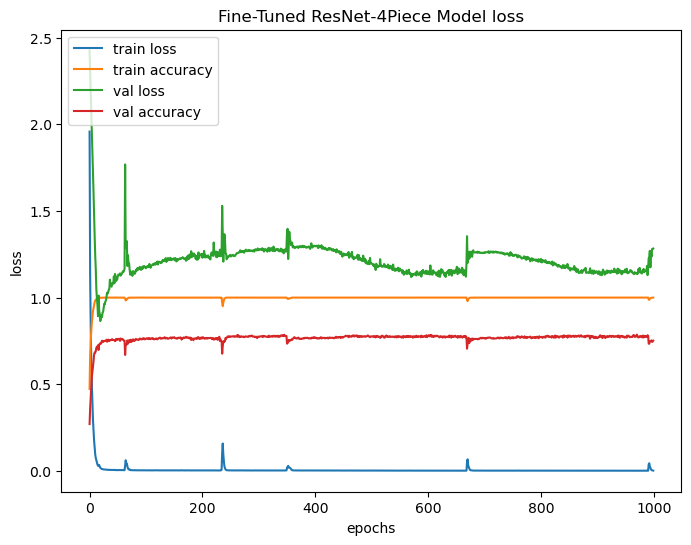

In [44]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [45]:
train_preds = model1.predict(fine_tune_data_train_red)

2022-10-08 15:19:00.105748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 15:19:00.167657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 3s 5ms/step


In [46]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [47]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [48]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [49]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [50]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [51]:
test_preds = model1.predict(fine_tune_data_test_red)

25/25 [==============================] - 0s 7ms/step


In [52]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [53]:
test_pred_labels

array([11,  8,  6, 11, 14,  6, 13, 12, 14,  1,  6, 15,  7, 14, 13, 11,  0,
        9,  6, 11,  8, 14,  3, 12,  6,  0,  3, 12,  3,  3, 11,  1,  9,  2,
        6,  8,  4,  7, 11,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12,  0, 11, 14,  0,  9,  9,  2, 15, 13, 11, 11,  6, 12,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12,  0, 11,  0, 12, 12,  9,
        8, 13, 13, 13,  1, 10, 11,  4, 10,  1, 15, 11,  8, 13, 10,  3,  7,
        5,  9,  1, 14,  8,  2, 12, 12,  7,  5,  9,  4, 12, 12, 12, 15, 11,
        6, 13,  1,  0,  9, 13,  5, 11,  6,  0,  3,  3, 11,  6,  1,  6,  9,
       14, 10,  7,  2, 10,  8,  4, 12,  8,  5,  8,  4,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13,  5, 10, 11, 11, 11, 11,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8, 10,  6, 13,  5,  4, 12,  8,  0,  9,
       13,  5,  5,  0, 10

In [54]:
np.sum(test_pred_labels == test_labels['label'])

601

In [55]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
14,203,./Data/train/train/203.tif,1
19,372,./Data/train/train/372.tif,13
...,...,...,...
780,15571,./Data/train/train/15571.tif,14
788,15687,./Data/train/train/15687.tif,12
792,15735,./Data/train/train/15735.tif,5
797,15832,./Data/train/train/15832.tif,11


In [56]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.688525,0.777778,0.730435,54
1,0.621622,0.522727,0.567901,44
2,0.886364,0.906977,0.896552,43
3,0.851064,0.869565,0.860215,46
4,0.829268,0.944444,0.883117,36
5,0.612245,0.600000,0.606061,50
6,0.816327,0.869565,0.842105,46
7,0.770833,0.711538,0.740000,52
8,0.866667,0.962963,0.912281,54
9,0.837209,0.765957,0.800000,47


In [57]:
np.mean(fscore)

0.7512490570020556

#### On Validation Data

Generating Predictions for the Validation Set

In [58]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [59]:
fine_tune_data_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')

In [60]:
fine_tune_data_validation.shape

(900, 5, 2048)

In [61]:
valid_preds = model1.predict(fine_tune_data_validation)

19/29 [==================>...........] - ETA: 0s

2022-10-08 15:19:55.048157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-08 15:19:55.104754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 13ms/step


In [62]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [63]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,9
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,5


In [64]:
submission_data.to_csv('./Submissions/submission-resnet-4p-lstm.csv', index=False)